<a href="https://colab.research.google.com/github/Tarasidze/mashine_learning/blob/practical_ml_keras/practical_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Load Cats and Dogs dataset

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  99.0M      0  0:00:07  0:00:07 --:--:-- 82.7M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [5]:
!ls PetImages

Cat  Dog


Filter out corrupted images

JFIF in headers

In [6]:
import os

num_skipped = 0

for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Generate a Dataset

In [7]:
from tensorflow.python.ops.batch_ops import batch
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualize the data

There are the first 9 images in the training dataset. As you can see, label 1 is a "dog" and label 0 is a "cat"

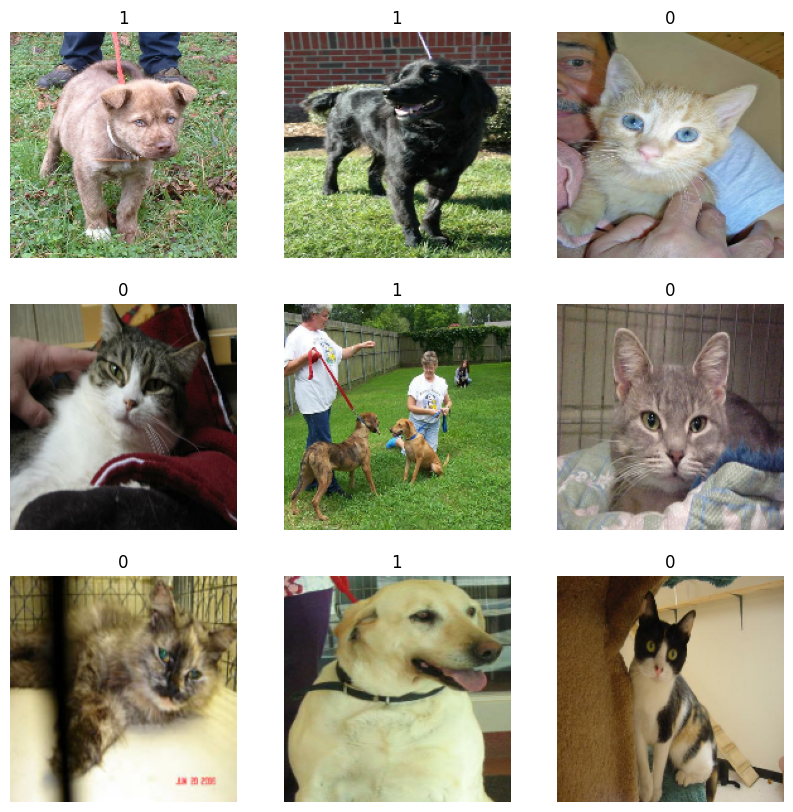

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")


# Using images data augmentation
When you don not have a large image dataset, it's a good practice to artificially introduce sample diversity dy applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotation. this helps expose the model to different aspects of the training data while slowing down overfitting.

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize how the augmented samples look like, by applying **data_augmentation** repeatedly to the first image in the dataset




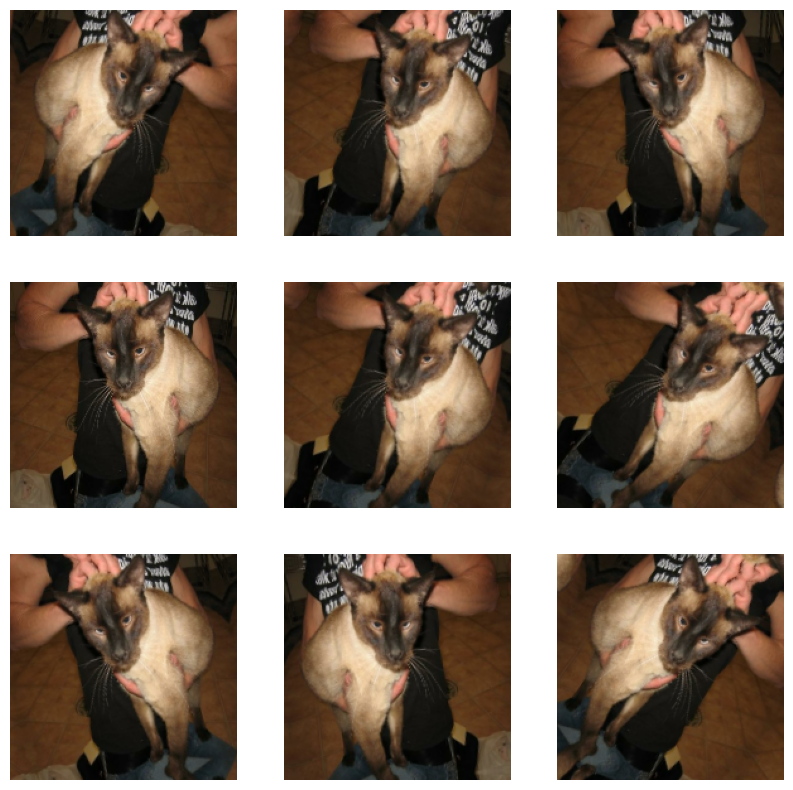

In [10]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


# Standartazing the data
Our images are already in standart size (180x180), as they are yield as continuous **float32** batches by our dataset. However, their RGB channel values are in the **[0, 255]** range. This is not ideal for a neural network; in general you shoul seek to make your input values small. Here we will standartize vales to be in the **[0, 1]** by using a **Rescaling** layer at the start of our model.

# Two option to preprocess the data
There are two ways youcould be using the data_augmentation preprocessor:

**Option 1: Make it part of the model, like this:**



```
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
```

With this options, your data augmentation will happen on device, synchronosly with the rest of model execution, meaning that it will benefit from GPU acceleration.
Note that data augmentation is inactive at test time, so the the imput samples will  only be augmanted during **fit()**, not when calling **evaluate()** or **predict()**.
If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to abtain a dataset that yields batches of augmented images, like this.



```
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, train=True), y)
)
```

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into model. If you're train on CPU, this is better option, since makes data augmentation asynchronous and non-blocking.
In our case, we'll go with the fith option.


# Configure the dataset for performance
Let's make sure to use buffered prefetching so can ield data from disk without having I/O becoming blocking

In [19]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model
We'll build a small version of the Xception network. We haven't particulary tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using **Keras Tuner**

Note that:
- We start the model with the **data_augmentation** preprocessor, followed by a **Rescaling** layer.
- We include a **Dropout** layer before the final classification layer

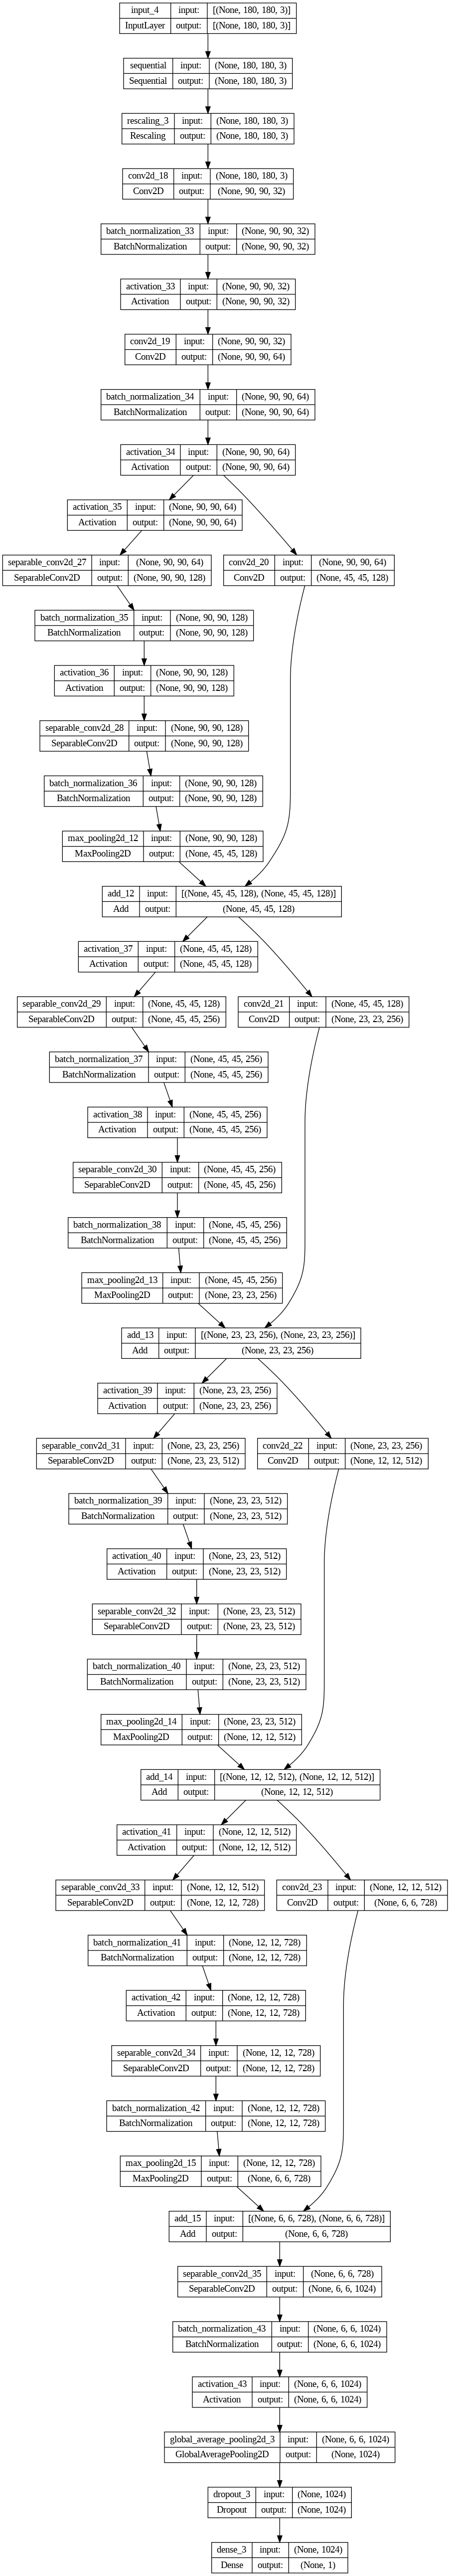

In [44]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  #input augmantation block
  x = data_augmentation(inputs)

  #entry block
  x = layers.Rescaling(1.0 / 250)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x #Set aside residual

  for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    #Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [47]:
epochs = 33

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/33
586/586 [==============================] - 121s 178ms/step - loss: 0.2220 - accuracy: 0.9080 - val_loss: 0.3468 - val_accuracy: 0.8501
Epoch 2/33
586/586 [==============================] - 103s 175ms/step - loss: 0.2013 - accuracy: 0.9181 - val_loss: 0.1630 - val_accuracy: 0.9351
Epoch 3/33
586/586 [==============================] - 103s 176ms/step - loss: 0.1795 - accuracy: 0.9239 - val_loss: 0.1567 - val_accuracy: 0.9381
Epoch 4/33
586/586 [==============================] - 103s 175ms/step - loss: 0.1660 - accuracy: 0.9309 - val_loss: 0.3364 - val_accuracy: 0.8387
Epoch 5/33
586/586 [==============================] - 103s 176ms/step - loss: 0.1616 - accuracy: 0.9327 - val_loss: 0.2170 - val_accuracy: 0.9058
Epoch 6/33
586/586 [==============================] - 106s 181ms/step - loss: 0.1476 - accuracy: 0.9400 - val_loss: 0.2692 - val_accuracy: 0.9020
Epoch 7/33
586/586 [==============================] - 103s 176ms/step - loss: 0.1431 - accuracy: 0.9412 - val_loss: 0.1613 -

# Run inference on new data

1/1 [==============================] - 0s 58ms/step
[5.4820106e-07]
This image is 99.9999 percent cat and 0.0001 percent dog


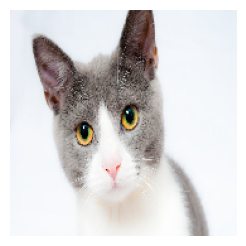

In [50]:
img = keras.preprocessing.image.load_img(
    "test_imgs/cat.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 3, i + 1)
plt.imshow(img)
plt.axis("off")

print(score)
print(
    "This image is %0.4f percent cat and %0.4f percent dog"
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 53ms/step
[1.]
This image is 0.0000 percent cat and 100.0000 percent dog


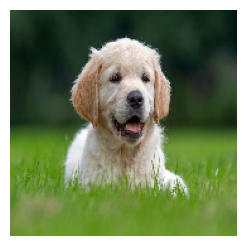

In [52]:
img = keras.preprocessing.image.load_img(
    "test_imgs/dog.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 3, i + 1)
plt.imshow(img)
plt.axis("off")

print(score)
print(
    "This image is %0.4f percent cat and %0.4f percent dog"
    % (100 * (1 - score), 100 * score)
)